##### DI: experimental code, might have bugs

- replicates the experiments in https://arxiv.org/abs/1802.02538

In [13]:
from functools import partial
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as dist
import pyro
import pyro.distributions as pyro_dist
from pyro.nn import PyroSample, PyroModule

In [14]:
# Bayesian linear regression: y~N(Xbeta, sigma^2)
n = 10000 # number of samples
d = 100   # number of features
m = 250  # number of replications

torch.manual_seed(20201028)
betas = dist.Normal(0, 1).sample(torch.Size([d])) # "true betas?" these are actually not needed.
x = dist.Normal(0, 1).sample(torch.Size([n, d])) 

torch.manual_seed(20201028)
# priors?
b0 = dist.Normal(0, 1).sample(torch.Size([d, m])) 
sigma0 = dist.Gamma(0.5, 0.5).sample(torch.Size([m])) 
y_mean = torch.matmul(x, b0) # "syntethic data"
prob = torch.zeros(m, d+1)

In [15]:
# y shape is [n_samples x n_datasets]
print(y_mean.shape)
# x shape is [n_samples, n_features] and applies to all datasets
print(x.shape)

torch.Size([10000, 250])
torch.Size([10000, 100])


In [4]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[torch.nn.Linear](in_features, out_features, bias=False)
        self.linear.weight = PyroSample(pyro_dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        
        
    def forward(self, x, y=None):
        sigma = pyro.sample("sigma",  pyro_dist.Gamma(0.5, 0.5))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", pyro_dist.Normal(mean, sigma), obs=y)
        return mean
    

model = BayesianRegression(d, 1)
guide = AutoDiagonalNormal(model) # Stochastic Mean field
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

def run_vi(x_data, y_data, svi, model, guide, num_iterations=int(1e4), num_post_samples=int(1e4)):    
    pyro.clear_param_store()
    
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
    guide.requires_grad_(False)
    predictive = Predictive(
        model, guide=guide, num_samples=num_post_samples, return_sites=("linear.weight", "sigma",)
    )
    
    samples = predictive(x_data)
    return samples

In [ ]:
###################################################################
## Load the p-values directly, the below takes a while to compute 
###################################################################

In [ ]:
def diagnose_vi_VSBC(vi_sampler, num_runs=150, ):
    """vi sampler should come with everything """
    

In [5]:
if False:
    for i in range(m):
        tic = time.time()
        y_sim = y_mean[:, i] + dist.Normal(0, sigma0[i]).sample(torch.Size([n]))
        # do VI
        samples = run_vi(x, y_sim, svi, model, guide)

        b_sim = samples["linear.weight"]
        b_mean = b_sim.mean(axis=0).reshape(-1, )
        b_sd = b_sim.std(axis=0).reshape(-1, )
        sigma_sim_log = torch.log(samples["sigma"])

        prob[i]=torch.cat((
            dist.Normal(b_mean, b_sd).cdf(b0[:, i]),
            dist.Normal(sigma_sim_log.mean(), sigma_sim_log.std()).cdf(torch.log(sigma0[i])).reshape(1, )
        ))
        toc = time.time()
        if i % 10 == 0:
            print(f"{i}/{m}... Last run lasted: {toc-tic} sec")
    
    probnp = prob.numpy()
    pd.DataFrame(probnp).to_csv("prob_fig1.csv")
            
else:
    probnp = pd.read_csv("results/prob_fig1.csv", index_col=0).values


0/250... Last run lasted: 35.82115697860718 sec
10/250... Last run lasted: 31.583512783050537 sec
20/250... Last run lasted: 31.45512294769287 sec
30/250... Last run lasted: 33.86094331741333 sec
40/250... Last run lasted: 31.590176105499268 sec
50/250... Last run lasted: 31.693382263183594 sec
60/250... Last run lasted: 32.963562965393066 sec
70/250... Last run lasted: 33.84242296218872 sec
80/250... Last run lasted: 37.159234046936035 sec
90/250... Last run lasted: 39.029316902160645 sec
100/250... Last run lasted: 37.443867206573486 sec
110/250... Last run lasted: 37.00340676307678 sec
120/250... Last run lasted: 38.388418674468994 sec
130/250... Last run lasted: 36.74188804626465 sec
140/250... Last run lasted: 36.21094012260437 sec
150/250... Last run lasted: 38.0653817653656 sec
160/250... Last run lasted: 37.13709592819214 sec
170/250... Last run lasted: 39.21133995056152 sec
180/250... Last run lasted: 39.268141746520996 sec
190/250... Last run lasted: 37.20742678642273 sec
200

In [12]:
40*250/60/60

2.7777777777777777

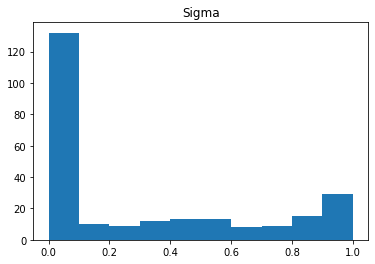

In [7]:
plt.hist(probnp[:, -1])
plt.title("Sigma")
plt.show()

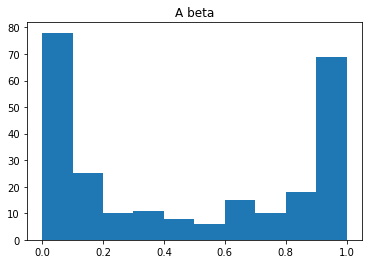

In [10]:
plt.hist(probnp[:, 30])
plt.title("A beta")
plt.show()

---------------

### PSIS

In [ ]:
model.